# Train the Model

If you need to download the model weights this can be done with:

`! wget -P data "https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5"`

Training from command line takes the form:

`keras_retinanet/bin/train.py csv` `/path/to/csv/file/containing/annotations` `/path/to/csv/file/containing/classes`

In [18]:
! ../keras-retinanet/keras_retinanet/bin/train.py --weights data/resnet50_coco_best_v2.1.0.h5 --epochs 10 --steps 500 csv data/tiled_seals/annotations.csv data/tiled_seals/classes.csv

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Epoch 1/10
500/500 [==============================] - 98s 196ms/step - loss: 1.6618 - regression_loss: 1.1760 - classification_loss: 0.4859

Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
Epoch 2/10
500/500 [==============================] - 91s 183ms/step - loss: 1.0332 - regression_loss: 0.8591 - classification_loss: 0.1741

Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
Epoch 3/10
500/500 [==============================] - 94s 188ms/step - loss: 0.8743 - regression_loss: 0.7411 - classification_loss: 0.1332

Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
Epoch 4/10
500/500 [==============================] - 96s 191ms/step - loss: 0.7563 - regression_loss: 0.6482 - classification_loss: 0.1081

Epoch 00004: saving model to ./snapshots/resnet50_csv_04.h5
Epoch 5/10
500/500 [==============================] - 97s 193ms/step - loss: 0.6751 - regression_loss: 0.5813 - classification_loss: 0.0939

Epoch 00005: saving model to ./snapshots/resnet50_csv_0

In [19]:
! ../keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/test_model.h5

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# Run Detection

### Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
from random import shuffle

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
#model_path = os.path.join('..', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

#model_path = os.path.join('..', 'snps', 'resnet50_csv_infer.h5')
model_path = 'snapshots/test_model.h5'

print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.load_model(model_path, backbone_name='resnet50', convert=True)

#print(model.summary())

# load label to names mapping for visualization purposes
#labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {0: 'seal'}

snapshots/test_model.h5
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Load imagery

In [3]:
# load imagery
image_dir = "data/tiled_seals/"

image_list = []
for root, dirs, files in os.walk(image_dir):  
    for filename in files:
        if filename.lower().endswith(('.png')):
            image_list.append(image_dir + filename)
print(len(image_list))

272


## Test out Detections

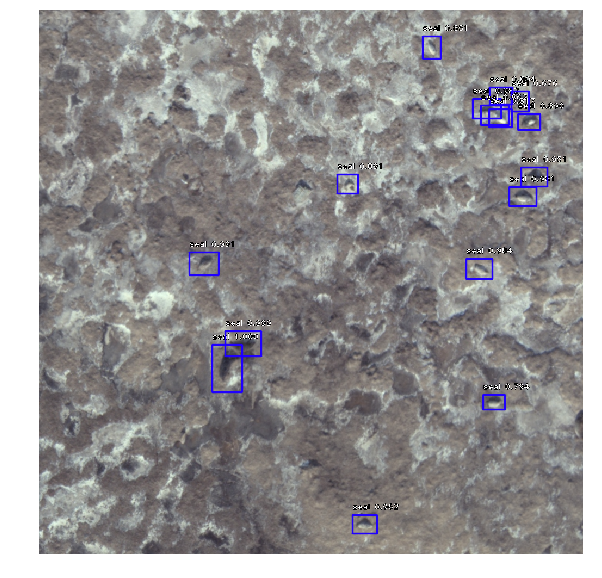

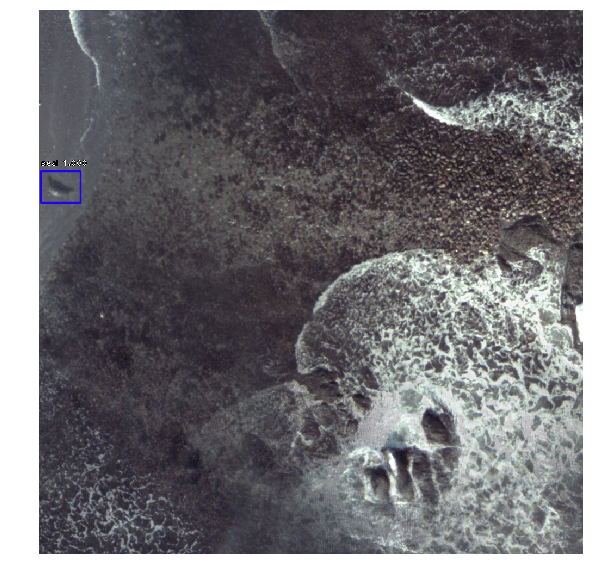

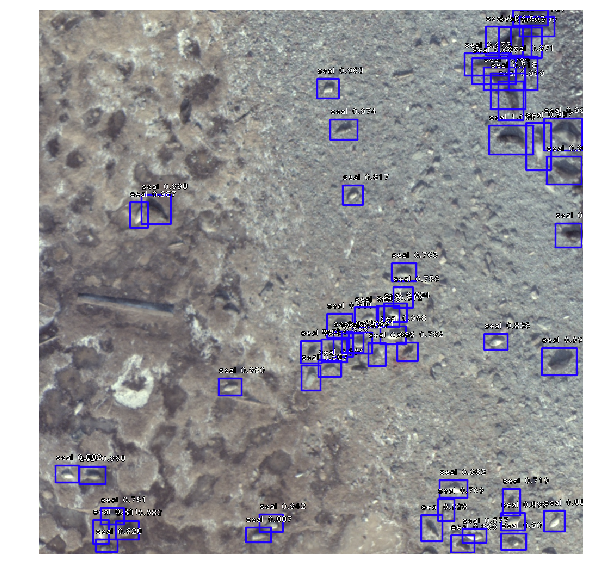

Finished, time per image: 0.0006720134440590354


In [9]:
visualize = True
min_score = 0.5 # this is the CNN's confidence that the detection is correct

detections = {}

total_time = 0

count = 0
detection_iterations = 3
shuffle(image_list)

for image_path in image_list:
    if count > 3:
        break
    else:
        count +=1
        
    image = read_image_bgr(image_path)

    if visualize:
        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start

    # correct for image scale
    boxes /= scale
    if any(score >= min_score for score in scores[0]):
        detections[image_path] = []

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < min_score:
            break

        #print(score)
        #print(box)

        # TODO this does create a slight error in the boxes, might be worth doing something like
        # list(map(str, box) but then would need to cast on the other end back to float
        b = box.astype(int)
        detections[image_path].append({"box" : b, "label" : label, "score" : score})

        if visualize:
            color = label_color(label)

            # b = box.astype(int)
            draw_box(draw, b, color=color)

            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)

    if any(score >= min_score for score in scores[0]):
        if visualize:
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
    
print("Finished, time per image:", total_time/len(image_list))

## Run Detections on All Tiles

In [12]:
visualize = False
min_score = 0.5 # this is the CNN's confidence that the detection is correct

detections = {}

total_time = 0

for image_path in image_list:
       
    image = read_image_bgr(image_path)

    if visualize:
        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start

    # correct for image scale
    boxes /= scale
    if any(score >= min_score for score in scores[0]):
        detections[image_path] = []

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < min_score:
            break

        #print(score)
        #print(box)

        # TODO this does create a slight error in the boxes, might be worth doing something like
        # list(map(str, box) but then would need to cast on the other end back to float
        b = box.astype(int)
        detections[image_path].append({"box" : b, "label" : label, "score" : score})

        if visualize:
            color = label_color(label)

            # b = box.astype(int)
            draw_box(draw, b, color=color)

            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)

    if any(score >= min_score for score in scores[0]):
        if visualize:
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
    
print("Finished, time per image:", total_time/len(image_list))

Finished, time per image: 0.04416285104611341


In [13]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

### write out the detections to a json file

In [14]:
with open('data/new_detections.json', 'w') as fp:
    json.dump(detections, fp, cls=MyEncoder)